# Part 2: Baseline Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
base_dir = "../input/dogs-vs-cats"
train_dir = os.path.join(base_dir, "train/train")
train_filenames = os.listdir(base_dir+ '/train/train')

## Label Images and Create File DataFrame

The class label is in the image name so we'll need to extract it. We'll ignore the numercial id as it provides no use for us.

In [2]:
train_data = pd.DataFrame(columns=['path', 'label'])
train_data['path'] = train_filenames 
train_data['label'] = train_data['path'].str[0:3]
train_data['path'] = (train_dir +"/" +train_data['path']).astype(str)
train_data.head()

,path,label
0,../input/dogs-vs-cats/train/train/cat.12461.jpg,cat
1,../input/dogs-vs-cats/train/train/dog.3443.jpg,dog
2,../input/dogs-vs-cats/train/train/dog.7971.jpg,dog
3,../input/dogs-vs-cats/train/train/dog.10728.jpg,dog
4,../input/dogs-vs-cats/train/train/dog.1942.jpg,dog


Since the data set is pretty big, we'll divide the data into 70% training data and 30% test data. The shuffle parameter is needed to prevent non-random assignment to to train and test set. With shuffle=True, we split the data randomly. For example, say that we have balanced binary classification data and it is ordered by labels. If we split it in 70:30 proportions to train and test, our test data would contain only the labels from one class. Random shuffling prevents this. The shuffle parameter is True by default.

In [3]:

train_df,test_df = train_test_split(train_data,train_size=0.7,shuffle=True,random_state=1)

Here's our traing and testing data set after splitting

In [4]:
train_df

,path,label
4289,../input/dogs-vs-cats/train/train/cat.836.jpg,cat
19621,../input/dogs-vs-cats/train/train/dog.11350.jpg,dog
14965,../input/dogs-vs-cats/train/train/cat.397.jpg,cat
12321,../input/dogs-vs-cats/train/train/cat.2857.jpg,cat
6269,../input/dogs-vs-cats/train/train/dog.1693.jpg,dog
...,...,...
10955,../input/dogs-vs-cats/train/train/cat.4792.jpg,cat
17289,../input/dogs-vs-cats/train/train/dog.827.jpg,dog
5192,../input/dogs-vs-cats/train/train/cat.5929.jpg,cat
12172,../input/dogs-vs-cats/train/train/dog.416.jpg,dog


In [5]:
test_df

,path,label
21492,../input/dogs-vs-cats/train/train/cat.7435.jpg,cat
9488,../input/dogs-vs-cats/train/train/dog.3827.jpg,dog
16933,../input/dogs-vs-cats/train/train/cat.11370.jpg,cat
12604,../input/dogs-vs-cats/train/train/cat.8950.jpg,cat
8222,../input/dogs-vs-cats/train/train/dog.11653.jpg,dog
...,...,...
13410,../input/dogs-vs-cats/train/train/dog.3168.jpg,dog
13158,../input/dogs-vs-cats/train/train/cat.4871.jpg,cat
3552,../input/dogs-vs-cats/train/train/dog.10182.jpg,dog
23203,../input/dogs-vs-cats/train/train/dog.8923.jpg,dog


## Load Image Data

In [6]:
Image_Size = (32,32)
Image_Shape = (32,32,3)
Batch_Size = 15 # tested [10-20], best 15 or 16

ImageDataGenerator is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed. It does not add the data.

In [7]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip = True, # flip images along the horizontal axis
    width_shift_range =0.1, # horizontal shift of images, tested [0-0.5], best is 0.1
    height_shift_range =0.1, # vertical shift of images,tested [0-0.5], best is 0.1
    validation_split=0.2,
    
)
test_generator = ImageDataGenerator(
    rescale = 1.0/255,
)


In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'path',
    y_col = 'label',
    target_size = Image_Size, # resize images
    class_mode = 'binary',
    batch_size = Batch_Size,
    seed = 42,
    subset = 'training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'path',
    y_col = 'label',
    target_size = Image_Size, # resize images
    class_mode = 'binary',
    batch_size = Batch_Size,
    seed = 42,
    subset = 'validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'path',
    y_col = 'label',
    target_size = Image_Size, # resize images
    class_mode = 'binary',
    batch_size = Batch_Size,
    shuffle = False,
)

Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


In [9]:
train_images.class_indices

{'cat': 0, 'dog': 1}

For our model, We will LeNet-5 CNN architeture to build our model.

In [10]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size = (5,5), activation = 'relu', input_shape = Image_Shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2),strides=(2, 2)))
model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2),strides=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2022-11-16 01:19:43.766988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:19:43.933370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:19:43.934319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:19:43.936188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [13]:
history = model.fit(
    train_images, 
    epochs = 50,
    validation_data = validation_images,
    callbacks = [
        EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        ),
        ReduceLROnPlateau(
            monitor = 'val_accuracy',
            patience = 2, # tested[2-6], best 2
            verbose = 1,
            factor = 0.5, # tested [0-0.5], best 0.5
            min_lr = 0.00001
        )
    ]
)

2022-11-16 01:19:46.951510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-16 01:19:48.682681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


934/934 [==============================] - 111s 111ms/step - loss: 0.6568 - accuracy: 0.6191 - val_loss: 0.6279 - val_accuracy: 0.6557
Epoch 2/50
934/934 [==============================] - 68s 73ms/step - loss: 0.6036 - accuracy: 0.6706 - val_loss: 0.5886 - val_accuracy: 0.6871
Epoch 3/50
934/934 [==============================] - 68s 73ms/step - loss: 0.5859 - accuracy: 0.6864 - val_loss: 0.6499 - val_accuracy: 0.6451
Epoch 4/50
934/934 [==============================] - 70s 75ms/step - loss: 0.5675 - accuracy: 0.7051 - val_loss: 0.7464 - val_accuracy: 0.5680

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
934/934 [==============================] - 70s 75ms/step - loss: 0.5456 - accuracy: 0.7241 - val_loss: 0.5680 - val_accuracy: 0.7049
Epoch 6/50
934/934 [==============================] - 72s 77ms/step - loss: 0.5384 - accuracy: 0.7259 - val_loss: 0.5517 - val_accuracy: 0.7177
Epoch 7/50
934/934 [==============================] - 69s 74ms/s

In [14]:
results = model.evaluate(test_images,verbose=0)
print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

Test Loss: 0.4986847937107086
Test Accuracy: 0.753333330154419


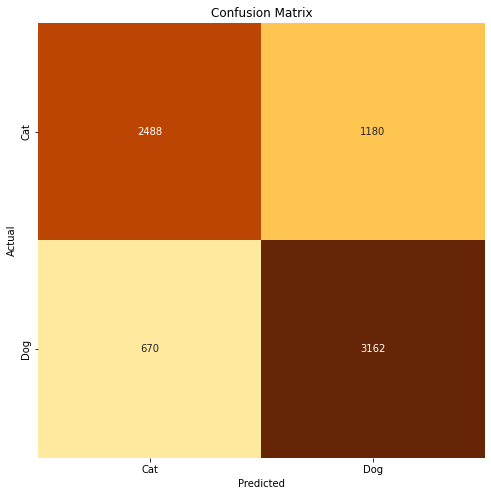

In [15]:

predictions = (model.predict(test_images) >=0.5).astype(int)

cm = confusion_matrix(test_images.labels,predictions,labels=[0,1])
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='YlOrBr',cbar=False)
plt.xticks(ticks=[0.5,1.5],labels=['Cat','Dog'])
plt.yticks(ticks=[0.5,1.5],labels=['Cat','Dog'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


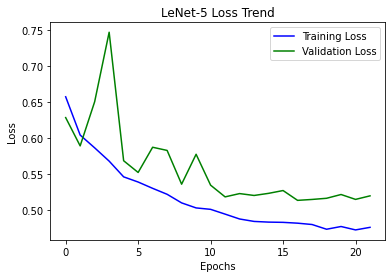

In [16]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LeNet-5 Loss Trend')
plt.plot(history.history['loss'], 'blue', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.legend()
plt.show()

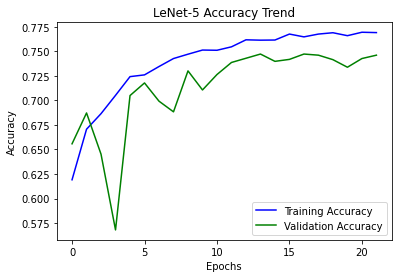

In [17]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LeNet-5 Accuracy Trend')
plt.plot(history.history['accuracy'], 'blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'green', label='Validation Accuracy')
plt.legend()
plt.show()